In [1]:
# All Imports

from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import random
import time
import pydicom
import glob
from numba import jit
from skimage import filters
import copy
from scipy import ndimage, misc


#import cv2
import sys
import matplotlib.pyplot as plt
import random
#from scipy.misc import imresize

import copy


# GAN model


import matplotlib.pyplot as plt
import sys

#from scipy.misc import imsave
import scipy.stats
from skimage.measure import compare_ssim as ssim
import pydicom
from sklearn.cluster import KMeans
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
from skimage import exposure
import glob
#from scipy.misc import imread
from sklearn.metrics import mean_squared_error
from skimage.measure import compare_psnr
import numpy
from numpy.fft import fft2, ifft2, fftshift
import scipy.ndimage.interpolation as ndii

import torch
import torch.utils.data as data_utils
import torch.optim as optim
from torch.autograd import Variable

import torch.nn as nn

In [7]:
# [STAR] PyTorch models for training the regularizer


class RegCNN(nn.Module):
    def __init__ (self):
        super().__init__()
        
        self.out_features = 125
        self.in_features  = 125
        
        self.weight = torch.nn.Parameter(torch.randn(self.out_features, self.in_features))
        self.bias   = torch.nn.Parameter(torch.randn(self.out_features, 1))

    def forward(self, x):
        x = torch.matmul(self.weight, x)
        x = self.bias + x
        x = torch.tanh(x)
        x = torch.mean(x, dim=0)
        return(x)

class RegCNNA(nn.Module):
    def __init__ (self):
        super().__init__()
        
        self.in_features   = 125
        self.out_features1 = 125
        self.out_features2 = 125
        self.out_features3 =   5
        
        self.weight1 = torch.nn.Parameter(torch.randn(self.out_features1, self.in_features))
        self.bias1   = torch.nn.Parameter(torch.randn(self.out_features1, 1))
        
        self.weight2 = torch.nn.Parameter(torch.randn(self.out_features2, self.out_features1))
        self.bias2   = torch.nn.Parameter(torch.randn(self.out_features2, 1))
        
        #self.weight3 = torch.nn.Parameter(torch.randn(self.out_features3, self.out_features2))
        #self.bias3   = torch.nn.Parameter(torch.randn(self.out_features3, 1))

    def forward(self, x):
        x = torch.matmul(self.weight1, x)
        x = self.bias1 + x
        x = torch.tanh(x)
        
        x = torch.matmul(self.weight2, x)
        x = self.bias2 + x
        x = torch.tanh(x)
        
        #x = torch.matmul(self.weight3, x)
        #x = self.bias3 + x
        #x = torch.tanh(x)
        #print(x[124])
        
        x = torch.mean(x, dim=0)
        return x

class RegCNNB(nn.Module):
    def __init__ (self):
        super().__init__()
        
        self.in_features   = 125
        self.out_features1 = 125
        self.out_features2 = 125
        self.out_features3 =   5
        
        #self.weight1 = torch.nn.Parameter(torch.randn(self.out_features1, self.in_features))
        #self.bias1   = torch.nn.Parameter(torch.randn(self.out_features1, 1))
        
        #self.weight2 = torch.nn.Parameter(torch.randn(self.out_features2, self.out_features1))
        #self.bias2   = torch.nn.Parameter(torch.randn(self.out_features2, 1))
        
        #self.weight3 = torch.nn.Parameter(torch.randn(self.out_features3, self.out_features2))
        #self.bias3   = torch.nn.Parameter(torch.randn(self.out_features3, 1))
        
        self.linear1  = torch.nn.Linear(self.in_features,   self.out_features1, bias=True)
        self.linear2  = torch.nn.Linear(self.out_features1, self.out_features2, bias=True)
        
    def forward(self, x):
        #x = self.linear1(x)
        #x = torch.relu(x)
        
        #x = self.linear2(x)
        #x = torch.relu(x)
        
        #x = torch.matmul(self.weight1, x)
        #x = self.bias1 + x
        #x = torch.tanh(x)
        
        #x = torch.matmul(self.weight2, x)
        #x = self.bias2 + x
        #x = torch.tanh(x)
        
        #x = torch.matmul(self.weight3, x)
        #x = self.bias3 + x
        #x = torch.tanh(x)
        #print(x[124])
        
        #x = torch.mean(x, dim=0)
        return x

class RegCNNC(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.filter0 = 16
        self.filter1 = 16
        self.filter2 = 8
        self.filter3 = 64
        self.filter4 = 64
        
        self.conv_block1 = nn.Sequential(
            nn.Conv3d(1, self.filter0, kernel_size=5, stride=1, padding=2),
            nn.ReLU())
        
        #self.conv_block2 = nn.Sequential(
        #    nn.Conv3d(self.filter0, self.filter1, kernel_size=5, stride=1, padding=2),
        #    nn.ReLU())
        
        #self.conv_block3 = nn.Sequential(
        #    nn.Conv3d(self.filter1, 1, kernel_size=5, stride=1, padding=2),
        #    nn.ReLU())
            #nn.MaxPool3d(2, stride=2))
        
#         self.conv_block4 = nn.Sequential(
#             nn.Conv3d(self.filter2, self.filter3, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool3d(2, stride=2))
        
#         self.conv_block5 = nn.Sequential(
#             nn.Conv3d(self.filter3, self.filter4, kernel_size=3, stride=1, padding=1),
#             nn.ReLU())
        #self.conv_block4 = nn.MaxPool3d(2, stride=2)
        

    def forward(self, x):
        x = self.conv_block1(x)
        #print('x shape is ', x.shape)
        #x = self.conv_block2(x)
        #print('x shape is ', x.shape)
        #x = self.conv_block3(x)
        
        out = torch.sum(x, 1)
        out = torch.unsqueeze(out, 1)
        return out

class RegCNND(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.filter0 = 8
        self.filter1 = 16
        self.filter2 = 8
        self.filter3 = 64
        self.filter4 = 64
        
        self.conv_block1 = nn.Sequential(
            nn.Conv3d(1, self.filter0, kernel_size=5, stride=1, padding=0),
            nn.ReLU())
        

    def forward(self, x):
        x   = self.conv_block1(x)
        x   = torch.sum(x, 1)
        
        out = x
        out = torch.reshape(out, [-1, 1])
        return out

# model  = RegCNND()
# inx    = torch.tensor(np.random.rand(10, 1, 5, 5, 5).astype('float32'))
# print(inx.shape)
# result = model.forward(inx)
# print(result.shape)

In [2]:
# [STAR] All the paths for training the model

projectionpath        = '/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/NORMAL/'
highprojectionpath    = '/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/DOUBLE/'
savepath              = '/media/pranjal/newdrive1/DBT-PROJ-DENOISE/'


modelname = "normal-to-three-huber-0.9"

In [4]:
# [STAR] Helper functions for training the de-noising CNN


def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def get_crop_image(lowimg, highimg):
    factor = 1
    
    #slice_index = random.randint(0, 24)
    #lowimg  = lowimg[slice_index]
    #highimg = highimg[slice_index]

    thresh  = threshold_otsu(lowimg)
    binary  = lowimg < thresh
    result  = np.multiply(binary, lowimg)

    rmin, rmax, cmin, cmax = bbox2(result)
    resultlowimg = result[rmin:rmax, cmin:cmax]
    resultlowimg = resultlowimg.astype(float)

    result        = np.multiply(binary, highimg)
    resulthighimg = result[rmin:rmax, cmin:cmax]
    resulthighimg = resulthighimg.astype(float)
    
    return resultlowimg, resulthighimg
    
def get_train_data_proj(lowimg, highimg, epoch, batch_size):
    highdose = []
    lowdose  = []
    cliplimit = 0
    
    imgshape = 256
    
    
    # loop till samples of size batch_size with atleast 90% occupancy is not obtained
    crop_count = 0
    
    rowst = lowimg.shape[0]
    colst = lowimg.shape[1]
    
    while(crop_count < batch_size):
        cropimgx = random.randint(1, rowst-imgshape)
        cropimgy = random.randint(1, colst-imgshape)
        
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov = np.sum(lowimg_crop > cliplimit)
        # atleast 90% occupancy should be there
        if nonzerov*1.0/(imgshape*imgshape) < 0.65:
            continue
        
        highimg_crop = highimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        
        #prob = random.randint(0, 100)
        #if prob < 50:
        #    lowimg_crop  = np.fliplr(lowimg_crop)
        #    highimg_crop = np.fliplr(highimg_crop)
        
        #lowimg_crop_mean  = np.mean(lowimg_crop.flatten())
        #highimg_crop_mean = np.mean(highimg_crop.flatten())
        #diff_mean         = highimg_crop_mean -  lowimg_crop_mean
        
        lowdose.append(lowimg_crop)
        highdose.append(highimg_crop)
        
        crop_count = crop_count+1
        
    return np.array(lowdose), np.array(highdose)

def mse(x, y):
    return np.linalg.norm(x - y)

def test_on_whole_proj_200(lowfilename, model):
    highdose = []
    lowdose  = []
    cliplimit = 0
    imgshape  = 200
    
    ds             = pydicom.dcmread(lowfilename)
    limg           = ds.pixel_array
    original_image = copy.deepcopy(limg)
    
    
    cleanimage = np.zeros(limg.shape)
    
    thresh      = threshold_otsu(limg)
    binarymax   = limg > thresh
    
    
    outsideimage_mask = limg > thresh
    insideimage_mask  = limg < thresh
    
    restimage   = binarymax#np.multiply(binarymax, limg)
    minvalue    = np.min(limg)
    
    binary  = limg <= thresh
    limg    = limg - np.min(limg)
    binary1 = limg >= 0
    
    newbinary    = np.multiply(binary, binary1)
    result       = np.multiply(newbinary, limg)
    resultlowimg = result
    resultlowimg = resultlowimg.astype(float)
    resultlowimg = resultlowimg/(thresh/2)
    lowimg       = resultlowimg-1
    
    #print(np.max(lowimg), np.mean(lowimg), np.min(lowimg), thresh)
    
    rowst = limg.shape[0]
    colst = limg.shape[1]
    
    # For top row
    i = 0
    j = 0
    while(j+imgshape < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             j = j+imgshape
#             continue
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        j = j+imgshape
    
    
    # For bottom row
    i = rowst-imgshape
    j = 0
    while(j+imgshape < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             j = j+imgshape
#             continue
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        j = j+imgshape
    
    # For rightmost column
    j = colst-imgshape
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             i = i+imgshape
#             continue    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        i = i+imgshape
    
    # For leftmost column
    j = 0
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             i = i+imgshape
#             continue
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        i = i+imgshape
    
    halfvalue    = int(imgshape/2)
    quartervalue = int(imgshape/4)#+int(imgshape/2)
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    while(i+imgshape < rowst):
        # re-initialize the counter for j
        j = 0
        while(j+imgshape < colst):
            cropimgx = i
            cropimgy = j
            
            tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
            
            lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
            nonzerov     = np.sum(lowimg_crop > cliplimit)
            
            # If it is not mostly occupied then don't process it
#             if nonzerov*1.0/(imgshape*imgshape) < 0.5:
#                 cleanimage[i+quartervalue:i+quartervalue+halfvalue, j+quartervalue:j+quartervalue+halfvalue] = tempimg[quartervalue:quartervalue+halfvalue, quartervalue:quartervalue+halfvalue]
#                 j = j+halfvalue
#                 continue
            
            before_mean = np.mean(tempimg)
            cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
            after_mean  = np.mean(cleanimg)
            cleanimg    = cleanimg - (after_mean-before_mean)
            
            #print(np.mean(tempimg), np.mean(cleanimg))
            
            cleanimage[i+quartervalue:i+quartervalue+halfvalue, j+quartervalue:j+quartervalue+halfvalue] = cleanimg[0, :, :, 0][quartervalue:quartervalue+halfvalue, quartervalue:quartervalue+halfvalue]
            j = j+halfvalue
        i = i+halfvalue
    
    #plt.hist(cleanimage.flatten(), bins=256, range=(cliplimit, 1.0), fc='k', ec='k')
    #plt.show()
    
    totalimage  = cleanimage+1
    binarynew   = binary
    
    img_adapteq = np.multiply(totalimage, binarynew)
    #print(np.max(img_adapteq), np.mean(img_adapteq), np.min(img_adapteq), thresh)
    
    mul_result   = img_adapteq*(thresh/2)
    mul_result   = mul_result+minvalue
    
    #print('restimage max  ', np.max(restimage))
    #print('mul_result max ', np.max(mul_result))
    
    tempvalue = np.min(mul_result)
    #restimage = restimage*np.max(mul_result)
    
    #mul_result   = mul_result + restimage
    #mul_result   = mul_result - tempvalue
    
    #print(mul_result.shape, restimage.shape)
    
    
    # Adding the Code to replace the oustide breast region with original values
    mul_result     = mul_result*insideimage_mask        # Get the inside region only
    original_image = original_image*outsideimage_mask   # Get the outside region only
    mul_result     = mul_result+original_image 
    
    #print(np.max(mul_result), np.mean(mul_result), np.min(mul_result))
    #print(np.mean(pt2), np.max(pt2), np.min(pt2))
    mul_result   = mul_result.astype(np.uint16)
    #print(np.mean(mul_result), np.max(mul_result), np.min(mul_result))
    
    ds.PixelData = mul_result.tostring()
    
    savename = lowfilename.split('\\')[-1]
    savepath = cleanprojpath+savename
    ds.save_as(savepath)
    
def test_on_whole_proj(lowfilename, model):
    highdose = []
    lowdose  = []
    cliplimit = 0.
    
    ds     = pydicom.dcmread(lowfilename)
    limg   = ds.pixel_array
    
    cleanimage = np.zeros(limg.shape)
    
    # get the histogram equalized image
    thresh      = threshold_otsu(limg)
    value_range = thresh - np.min(limg)
    binary  = limg <= thresh
    limg    = limg - np.min(limg)
    binary1 = limg >= 0
    newbinary = np.multiply(binary, binary1)
    result    = np.multiply(newbinary, limg)
    resultlowimg = result
    resultlowimg = resultlowimg.astype(float)
    resultlowimg = resultlowimg/thresh
    resultlowimg = exposure.equalize_adapthist(resultlowimg, clip_limit=cliplimit)
    lowimg       = resultlowimg
    
    rowst = limg.shape[0]
    colst = limg.shape[1]
    
    # For top row
    i = 0
    j = 0
    while(j+128 < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            j = j+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        j = j+128
    
    
    # For bottom row
    i = rowst-128
    j = 0
    while(j+128 < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            j = j+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        j = j+128
    
    # For rightmost column
    j = colst-128
    i = 0
    while(i+128 < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            i = i+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        i = i+128
    
    # For leftmost column
    j = 0
    i = 0
    while(i+128 < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            i = i+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        i = i+128
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    while(i+128 < rowst):
        # re-initialize the counter for j
        j = 0
        while(j+128 < colst):
            cropimgx = i
            cropimgy = j
                
            tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            
            lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            nonzerov     = np.sum(lowimg_crop >= cliplimit)
            
            # If it is not mostly occupied then don't process it
            if nonzerov*1.0/(128*128) < 0.9:
                cleanimage[i+64:i+128, j+64:j+128] = tempimg[32:96, 32:96]
                j = j+64
                continue
            
            cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
            cleanimage[i+64:i+128, j+64:j+128] = cleanimg[0, :, :, 0][32:96, 32:96]
            j = j+64
        i = i+64
    
    #plt.hist(cleanimage.flatten(), bins=256, range=(cliplimit, 1.0), fc='k', ec='k')
    #plt.show()
    
    totalimage  = cleanimage
    binarynew   = binary
    
    img_adapteq = np.multiply(totalimage, binarynew)
    
    print('value range is ', value_range)
    mul_result   = img_adapteq*value_range
    
    print('Max is ', np.max(mul_result))
    print('Min is ', np.min(mul_result))
    
    mul_result   = mul_result.astype(np.uint16)
    
    
    
    print('Max is ', np.max(mul_result))
    print('Min is ', np.min(mul_result))
    
    max_value = np.max(mul_result)
    mul_result[mul_result == 0] = max_value*2
    
    #plt.hist(mul_result.flatten(), bins=256, range=(np.min(mul_result)+0.01, np.max(mul_result)), fc='k', ec='k')
    #plt.show()
    
    ds.PixelData = mul_result.tostring()
    
    savename = lowfilename.split('\\')[-1]
    savepath = cleanprojpath+savename
    ds.save_as(savepath)

def test_on_whole_slice(lowfilename, highfilename, model, xindex, jindex):
    highdose = []
    lowdose  = []
    cliplimit = 0.03
    
    #projindex    = str(slicenum).zfill(2)+'.dcm'
    #lowfilename  = projectionpath+str(filenum)+'_20/_'+projindex
    #highfilename = highprojectionpath+str(filenum)+'_100/_'+projindex
    
    ds     = pydicom.dcmread(lowfilename)
    lowimg = ds.pixel_array
    
    ds      = pydicom.dcmread(highfilename)
    highimg = ds.pixel_array
    
    # get the cropped image
    lowimg, highimg =  get_crop_image(lowimg, highimg, cliplimit)
    
    totalimage      = []
    totalimagereal  = []
    totalimagerealh = []
    
    rowst = lowimg.shape[0]
    colst = lowimg.shape[1]
    
    print('Shape of Image is ', rowst, 'x', colst)
    
    # Change the indexing later to accomodate the full image view
    # Or second option is to do the averaging at the corner views
    
    # count of processed rows in the whole image
    processed_count_total = 0
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    
    while(i+128 < rowst):
        # for clean image from model
        newrow      = []
        # for the real lowdose image
        newrowreal  = []
        # for the real highdose image
        newrowrealh = []
        # count of images processed in a row
        processed_count_row = 0
        # re-initialize the counter for j
        j = 0
        
        while(j+128 < colst):
            cropimgx = i
            cropimgy = j
                
            tempimg  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            tempimgh = highimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            
            newrowreal.append(tempimg[32:96, 32:96])
            newrowrealh.append(tempimgh[32:96, 32:96])
            
#             nonzerov = np.sum(lowimg_crop >= cliplimit)
#             # If it is not mostly occupied then don't process it
#             if nonzerov*1.0/(128*128) < 0.9:
#                 newrow.append(tempimg[32:96, 32:96])
#                 processed_count_row = processed_count_row+1
#                 continue
            
            cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
            newrow.append(cleanimg[0, :, :, 0][32:96, 32:96])
            processed_count_row = processed_count_row+1
            
            if i  == (128*xindex) and j == (128*jindex):
                print('Clean Image SNR',    np.mean(cleanimg[0, :, :, 0])/np.std(cleanimg[0, :, :, 0]))
                print('Original Image SNR', np.mean(tempimg)/np.std(tempimg))
                print('HIGH Original Image SNR', np.mean(tempimgh)/np.std(tempimgh))
                
                ssim_low   = ssim(tempimgh, tempimg, data_range=tempimg.max() - tempimg.min())
                ssim_clean = ssim(tempimgh, cleanimg[0, :, :, 0], data_range=cleanimg[0, :, :, 0].max() - cleanimg[0, :, :, 0].min())
                
                print('SSIM low ',   ssim_low)
                print('SSIM clean ', ssim_clean)
                
                mse_clean   = mse(tempimgh, cleanimg[0, :, :, 0])
                mse_low     = mse(tempimgh, tempimg)
                
                print('MSE low ',   mse_low)
                print('MSE clean ', mse_clean)
                
                imsave('testimage.jpg', tempimg)
                imsave('clean2.jpg', cleanimg[0, :, :, 0])
                imsave('low2.jpg',   tempimg)
                imsave('high2.jpg',  tempimgh)
            j = j+64
        i = i+64
                
        combined = np.array(newrow)
        #print('newrow length is ', len(newrow), combined.shape)
        
        combined = np.hstack(combined.reshape(processed_count_row, 64, 64))
        totalimage.append(combined)
        
        combinedreal = np.array(newrowreal)
        combinedreal = np.hstack(combinedreal.reshape(processed_count_row, 64, 64))
        totalimagereal.append(combinedreal)
        
        combinedrealh = np.array(newrowrealh)
        combinedrealh = np.hstack(combinedrealh.reshape(processed_count_row, 64, 64))
        totalimagerealh.append(combinedrealh)
        
        # increment the rows processed count
        processed_count_total = processed_count_total+1
        
        #print('Shape of the combined image is ', combined.shape)
    
    totalimage = np.array(totalimage)
    totalimage = np.vstack(totalimage.reshape(processed_count_total, 64, processed_count_row*64))
    
    totalimagereal = np.array(totalimagereal)
    totalimagereal = np.vstack(totalimagereal.reshape(processed_count_total, 64, processed_count_row*64))
    
    totalimagerealh = np.array(totalimagerealh)
    totalimagerealh = np.vstack(totalimagerealh.reshape(processed_count_total, 64, processed_count_row*64))
    
    return totalimage, totalimagereal, totalimagerealh

image_indexes_result      = []
temp_image_indexes_result = []

def store_results(epoch, saveseed=5):
    global image_indexes_result
    global temp_image_indexes_result
    
    imgshape = 256
    
    # set the ids for saving the results
    random.seed(saveseed)
    
    projindex    = 55
    lowfilename  = projectionpath+'3200x1600x25.'+str(projindex)+'.raw'
    highfilename = highprojectionpath+'3200x1600x25.'+str(projindex)+'.raw'
    
    lowimg  = np.fromfile(lowfilename, dtype='float32')
    highimg = np.fromfile(highfilename, dtype='float32')
    lowvol  = np.reshape(lowimg, [25, 1600, 3200])/1250.0
    highvol = np.reshape(highimg, [25, 1600, 3200])/3750.0
    
    slice_index = 12#random.randint(0, 24)
    lowimg      = lowvol[slice_index]
    highimg     = highvol[slice_index]
    
    # get the cropped image
    lowimg, highimg =  get_crop_image(lowimg, highimg)
    
    r, c = 6, 6
    x, y = get_train_data_proj(lowimg, highimg, 1, 128)
    x = x-0.5
    y = y-0.5
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95)
    plt.tight_layout()
    fig, axs = plt.subplots(r, c, figsize=(30,10))
    cnt      = 0
    
    for i in range(r):
        for j in range(c):
            if len(image_indexes_result) == 0:
                imgindex = random.randint(1, 127)
                temp_image_indexes_result.append(imgindex)
            else:
                imgindex = image_indexes_result[cnt]
            
            cleanimg = aae.generator.predict(np.expand_dims([x[imgindex]], axis=3))
            combined = np.array([x[imgindex]+0.5, cleanimg[0, :, :, 0]+0.5, y[imgindex]+0.5])
            combined = np.hstack(combined.reshape(3,imgshape,imgshape))
            #print(cleanimg[0, :, :, 0].shape, y[imgindex].shape, combined.shape)
            axs[i,j].imshow(combined, cmap='gray')
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])
            axs[i,j].axis('off')
            cnt += 1
    if len(image_indexes_result) == 0:
        image_indexes_result = temp_image_indexes_result
    plt.subplots_adjust(wspace=0.1, hspace=0)
    fig.savefig(savepath+modelname+"-results/clean_%d.png" % epoch, bbox_inches='tight')
    plt.close()

In [7]:
# [STAR] Model for training the de-noising network

img_shape  = (256, 256, 1)

def huber_loss(y_true, y_pred, clip_delta=0.04):
    error        = y_true - y_pred
    cond         = tf.keras.backend.abs(error) < clip_delta
    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)
    return tf.where(cond, squared_loss, linear_loss)

def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
    return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))

class AdversarialAutoencoder():
    def __init__(self):
        self.optimizer1  = RMSprop(0.0005)
        self.optimizer2  = RMSprop(0.00001)
        
        self.clip_value = 0.01
        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        
        
        #self.discriminator.load_weights('/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/DBT_data/Results/vanilla-gan-weights-mse-0.1/discriminator_weights_8050.h5')
        self.d_arr = []
        self.g_arr = []
        
        # Build the encoder / decoder
        self.generator = self.build_generator()
         
        img = Input(shape=img_shape)
        # The generator takes the image, encodes it and reconstructs it
        # from the encoding
        reconstructed_img            = self.generator(img)
        #self.adversarial_autoencoder = Model(img, reconstructed_img)
        #self.adversarial_autoencoder.compile()
        # For the adversarial_autoencoder model we will only train the generator
        self.discriminator.trainable = False
        
        # The discriminator determines validity of the cleaned image
        validity = self.discriminator(reconstructed_img)

        # The adversarial_autoencoder model  (stacked generator and discriminator)
        self.adversarial_autoencoder = Model(img, [reconstructed_img, validity])
        self.adversarial_autoencoder.compile(loss=[huber_loss_mean, 'mse'],
            loss_weights=[0.9, 0.1],
            optimizer=self.optimizer2)
        
        self.discriminator.trainable = True
        self.discriminator.compile(loss='mse',
            optimizer=self.optimizer1, 
            metrics=['accuracy'])
        #self.discriminator.load_weights('/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/DBT_data/Results/gan-proj-mse-0.99-sub-weights/discriminator_weights_8400.h5')
        #self.generator.load_weights('/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/DBT_data/Results/gan-proj-mse-0.99-sub-weights/generator_weights_8400.h5')

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
    
    def build_autoencoder(self):
        self.generator.compile(loss=['mse'],optimizer=self.optimizer)
     
    def build_generator(self):
        x = Input(shape=img_shape)
        x1 = Conv2D(32, (3, 3), padding='same')(x)
        x1 = LeakyReLU(alpha=0.2)(x1)
        
        x2 = Conv2D(64, (3, 3), padding='same')(x1)
        #x2 = BatchNormalization(momentum=0.8)(x2)
        x2 = LeakyReLU(alpha=0.2)(x2)
        
        x3 = Conv2D(64, (3, 3), padding='same')(x2)
        #x3 = BatchNormalization(momentum=0.8)(x3)
        x3 = LeakyReLU(alpha=0.2)(x3)
        
        #x3_m = merge([x2, x3], mode='concat', concat_axis=3)
        x4 = Conv2D(64, (3, 3), padding='same')(x3)
        #x4 = BatchNormalization(momentum=0.8)(x4)
        x4 = LeakyReLU(alpha=0.2)(x4)
        #x6_i = merge([x2, x6], mode='concat', concat_axis=3)
        
        
        x5 = Conv2D(128, (3, 3), padding='same')(x4)\
        #x5 = BatchNormalization(momentum=0.8)(x5)
        x5 = LeakyReLU(alpha=0.2)(x5)
        
        #x7_i = merge([x1, x7], mode='concat', concat_axis=3)
        x6 = Conv2D(128, (3, 3), padding='same')(x5)
        x6 = LeakyReLU(alpha=0.2)(x6)
        
        x7 = Conv2D(64, (3, 3), padding='same')(x6)
        #x8 = BatchNormalization(momentum=0.8)(x8)
        x7 = LeakyReLU(alpha=0.2)(x7)
        #x7_m = merge([x1, x6], mode='concat', concat_axis=3)
        #x8    = Conv2D(1, (3, 3), activation='relu', padding='same')(x6)
        x8 = Conv2D(1, (3, 3), padding='same')(x7)
        x8 = LeakyReLU(alpha=0.2)(x8)
        
        out = keras.layers.Subtract()([x, x8])
        #out = ReLU()(out)
        model = Model(x, out)
        return model

    def build_discriminator(self):
        model = Sequential()
        model.add(Conv2D(64, (3, 3), input_shape=img_shape))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(64,  (3, 3),  strides=(2, 2)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(64, (3, 3)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        #         model.add(Conv2D(16, (6, 6),  strides=(2, 2)))
        #         model.add(LeakyReLU(alpha=0.2))
        #         model.add(Dropout(0.5))
        model.add(Conv2D(64, (3, 3),  strides=(2, 2)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(128, (3, 3)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, (3, 3),  strides=(2, 2)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Dense(1))
        return model
    
    def train_generator_autoencoder(self, epochs, batch_size=128):
        for epoch in range(epochs):
            # Load the dataset
            X_train, Y_train = get_train_data(epoch, batch_size)
            
            X_train = np.expand_dims(X_train, axis=3)
            Y_train = np.expand_dims(Y_train, axis=3)
            
            g_loss = self.generator.train_on_batch(X_train, Y_train)
            
            # Plot the progress
            print ("Epoch ", epoch, " G loss ", g_loss)
            if epoch%50 == 0:
                store_results(epoch)
                self.generator.save_weights(savepath+modelname+'-weights/generator_weights_'+str(epoch)+'.h5')
                self.discriminator.save_weights(savepath+modelname+'-weights/discriminator_weights_'+str(epoch)+'.h5')
    
    def train(self, epochs, batch_size=128, sampling=50, saveseed=5, startepoch=0, discriminator_epochs=5):
        for epoch in range(startepoch, epochs):
            # Train the discriminator 5 times
            #print('Training Discriminator ', epoch)
            
            projindex = str(random.randint(43, 68))#+'.dcm'
    
            lowfilename  = projectionpath+'3200x1600x25.'+str(projindex)+'.raw'
            highfilename = highprojectionpath+'3200x1600x25.'+str(projindex)+'.raw'

            lowimg  = np.fromfile(lowfilename, dtype='float32')
            highimg = np.fromfile(highfilename, dtype='float32')
            
            lowvol  = np.reshape(lowimg,  [25, 1600, 3200])/1250.0
            highvol = np.reshape(highimg, [25, 1600, 3200])/3750.0
            
            for itd in range(discriminator_epochs):
                slice_index = random.randint(0, 24)
                lowimg      = lowvol[slice_index]
                highimg     = highvol[slice_index]
                
                # get the cropped image
                lowimg, highimg =  get_crop_image(lowimg, highimg)
                
                # Load the dataset
                X_train, Y_train = get_train_data_proj(lowimg, highimg, epoch, batch_size)
                X_train = X_train - 0.5
                Y_train = Y_train - 0.5
                
                #print(X_train.shape, Y_train.shape)
                
                X_train = np.expand_dims(X_train, axis=3)
                Y_train = np.expand_dims(Y_train, axis=3)

                # Adversarial ground truths
                valid = np.ones((batch_size, 1))
                fake  = np.zeros((batch_size, 1))

                # ---------------------
                #  Train Discriminator
                # ---------------------
                # get the noisy image and feed it into the generator
                X_train_clean = self.generator.predict(X_train)

                # Train the discriminator (real classified as ones and generated as zeros)
                d_loss_real = self.discriminator.train_on_batch(Y_train, valid)
                d_loss_fake = self.discriminator.train_on_batch(X_train_clean, fake)
                d_loss      = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            #print('Training Generator ', epoch)
            # ---------------------
            #  Train Generator
            # ---------------------
            # Train the generator
            g_loss = self.adversarial_autoencoder.train_on_batch(X_train, [Y_train, valid])
            #print('g_loss ', g_loss)
            self.d_arr.append(d_loss)
            self.g_arr.append(g_loss)
            
            #print('Epoch ', epoch, ' Total D loss ', -d_loss, ' D loss real ', -d_loss_real, ' D loss fake ', d_loss_fake, ' G_loss ', g_loss[0], g_loss[1], g_loss[2])
            # Plot the progress
            #print ("%d [D loss: %f] [G loss: %f] [G loss: %f %f]" % (epoch, 1 - d_loss, 1 - g_loss[0], g_loss[0], g_loss[1]))
            #print('Epoch ', epoch, ' Total D loss ', -d_loss, ' G_loss ', g_loss[0], g_loss[1], g_loss[2])
            
            if epoch%sampling == 0:
                store_results(epoch, saveseed)
                self.generator.save_weights(savepath+modelname+'-weights/generator_weights_'+str(epoch)+'.h5')
                #self.discriminator.save_weights(savepath+modelname+'-weights/discriminator_weights_'+str(epoch)+'.h5')
            
            print ("%d [D loss: %f, mean_acc: %.2f%% real_acc: %.2f%% fake_acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], 100*d_loss_real[1], 100*d_loss_fake[1], g_loss[2]*0.0001, g_loss[1]*0.999))

In [8]:
# [STAR] Training loop of the model

aae = AdversarialAutoencoder()
# print(aae.generator.summary())
# print(aae.discriminator.summary())

In [ ]:
aae.train(epochs=25000, batch_size=32, sampling=50, saveseed=7590, startepoch=0)

In [ ]:
# [STAR] For denoising the projections of dicom files
from skimage.filters import unsharp_mask, threshold_local, threshold_minimum

def test_on_whole_proj_200(lowfilename, model):
    highdose = []
    lowdose  = []
    cliplimit = 0
    imgshape  = 256
    
    ds             = pydicom.dcmread(lowfilename)
    limg           = ds.pixel_array
    original_image = copy.deepcopy(limg)
    
    cleanimage        = np.zeros(limg.shape)
    thresh            = threshold_otsu(limg)
    
    outsideimage_mask = limg > thresh
    insideimage_mask  = limg < thresh
    
    binary  = limg <= thresh
    
    result       = np.multiply(binary, limg)
    resultlowimg = result
    resultlowimg = resultlowimg.astype(float)
    lowimg       = resultlowimg
    
    # Perform sharpening before de-noising
    #lowimg = unsharp_mask(lowimg, radius=3, amount=0.5, preserve_range=True)
    
    print(np.min(resultlowimg.flatten()), np.max(resultlowimg.flatten()))
    rowst = limg.shape[0]
    colst = limg.shape[1]
    
    # For top row
    i = 0
    j = 0
    while(j+imgshape < colst):
        cropimgx     = i
        cropimgy     = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        #cleanimg    = cleanimg*3750.0
        
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        j = j+imgshape
    
    
    # For bottom row
    i = rowst-imgshape
    j = 0
    while(j+imgshape < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        j = j+imgshape
    
    # For rightmost column
    j = colst-imgshape
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        i = i+imgshape
    
    # For leftmost column
    j = 0
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        i = i+imgshape
    
    halfvalue    = int(imgshape/2) # replacement size
    quartervalue = int(imgshape/4) # stride size 
    #+int(imgshape/2)
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    while(i+imgshape < rowst):
        # re-initialize the counter for j
        j = 0
        while(j+imgshape < colst):
            cropimgx = i
            cropimgy = j
            
            tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 -0.5
            lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
            nonzerov     = np.sum(lowimg_crop > cliplimit)
            
            before_mean = np.mean(tempimg)
            cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
            after_mean  = np.mean(cleanimg)
            #cleanimg    = cleanimg + before_mean
            cleanimg    = cleanimg - (after_mean-before_mean)
            #cleanimg[cleanimg < 0] = 0
            #print(after_mean, before_mean)
            cleanimage[i+quartervalue:i+quartervalue+halfvalue, j+quartervalue:j+quartervalue+halfvalue] = (cleanimg[0, :, :, 0]+0.5)[quartervalue:quartervalue+halfvalue, quartervalue:quartervalue+halfvalue]*1250
            #j = j+halfvalue
            j = j+quartervalue
        #i = i+halfvalue
        i = i+quartervalue
    
#     savename = lowfilename.split('/')[-1]
#     savepath = cleanprojpath+savename+'.npy'
#     np.save(savepath, cleanimage)
    
    #cleanimage[cleanimage < 0] = 0
    #cleanimage[cleanimage > 2000] = 2000
    
    totalimage  = cleanimage
    binarynew   = binary
    
    img_adapteq  = np.multiply(totalimage, binarynew)
    mul_result   = img_adapteq
    
    # Adding the Code to replace the oustide breast region with original values
    mul_result     = mul_result*insideimage_mask        # Get the inside region only
    mul_result[mul_result < 0] = 0
    print(np.min(mul_result.flatten()), np.max(mul_result.flatten()), mul_result.dtype, cleanimage.dtype, cleanimg.dtype)
    
    original_image = original_image*outsideimage_mask   # Get the outside region only
    mul_result     = mul_result+original_image 
    
    
    mul_result   = mul_result.astype(np.uint16)
    
    ds.PixelData = mul_result.tostring()
    
    savename = lowfilename.split('/')[-1]
    savepath = cleanprojpath+savename
    ds.save_as(savepath)
    


lowprojpath   = '/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/LE-L-CC/'
cleanprojpath = '/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/LE-L-CC-CLEAN1-750-HUBER/'

#/media/pranjal/newdrive1/DBT-PROJ-DENOISE/normal-to-three-huber-0.9-weights

aae = AdversarialAutoencoder()
aae.generator.load_weights('/media/pranjal/newdrive1/DBT-PROJ-DENOISE/normal-to-three-huber-0.9-weights/generator_weights_750.h5')
#aae.generator.load_weights('/media/pranjal/newdrive1/DBT-PROJ-DENOISE/normal-to-three-0.99-weights/generator_weights_400.h5')

files = glob.glob(lowprojpath+'*.IMA')

for f in files:
    print(f)
    test_on_whole_proj_200(f, aae)
    
    
#tensorflow.keras.losses.Huber(delta=1.5)
#tf.keras.losses.

In [ ]:
projindex = str(random.randint(43, 68))#+'.dcm'
epoch = 0
batch_size = 32

lowfilename  = projectionpath+'3200x1600x25.'+str(projindex)+'.raw'
highfilename = highprojectionpath+'3200x1600x25.'+str(projindex)+'.raw'

lowimg  = np.fromfile(lowfilename, dtype='float32')
highimg = np.fromfile(highfilename, dtype='float32')

lowvol  = np.reshape(lowimg, [25, 1600, 3200])/1250.0
highvol = np.reshape(highimg, [25, 1600, 3200])/3750.0


slice_index = random.randint(0, 24)
lowimg      = lowvol[slice_index]
highimg     = highvol[slice_index]

# get the cropped image
lowimg, highimg =  get_crop_image(lowimg, highimg)

# Load the dataset
X_train, Y_train = get_train_data_proj(lowimg, highimg, epoch, batch_size)
X_train  = X_train  - 0.5
Y_train  = Y_train  - 0.5


print(X_train.shape, Y_train.shape)

In [5]:
# [STAR] For generating the projections

@jit(nopython=True, parallel=True)
def my_divide(x, y):
    return np.divide(x, y)

@jit(nopython=True, parallel=True)
def my_add(x, y):
    return np.add(x, y)

@jit(nopython=True, parallel=True)
def my_mul(x, y):
    return np.multiply(x, y)




#testvol = ndimage.zoom(testvol, 0.25, order=1)
#testvol = np.zeros([320, 448, 800], dtype='uint8')

scaling_factor = 1

SOD       = 65/0.025
ODD       = 4.5/0.025
detWidth  = 0.0085/0.025 #/(0.0255/scaling_factor)   # size of each detector pixel
detHeight = detWidth        # size of each detector pixel
detRows   = 3584
detCols   = 1600


num_angles = 25

#estimate = np.fromfile("/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/DBT_data/ClinicalExample/CE-05_R/ce.800x448x320.05-le.raw", dtype='float32')
#estimate = np.reshape(estimate, [320, 448, 800])


a       = sio.loadmat("/media/pranjal/cewitdata2/DBT-PROJ-DENOISE/attenuation_values_cropped/LE/1.mat")["head"]
testvol = np.rollaxis(a, 2, 0)
testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])
testvol = testvol/65.0


vol_geom = astra.create_vol_geom(int(testvol.shape[1]), int(testvol.shape[2]), int(testvol.shape[0]))
proj_arr = np.zeros((num_angles, detCols, detRows), dtype='float16')
testones = np.ones([int(testvol.shape[0]), int(testvol.shape[1]), int(testvol.shape[2])],  dtype='uint8')
estimate = np.zeros([int(testvol.shape[0]), int(testvol.shape[1]), int(testvol.shape[2])], dtype='float16')

print('Starting Recon')


#proj_arr = np.array(proj_arr).astype('float16')
#proj_arr = np.rollaxis(proj_arr, 1, 0)
#proj_arr = proj_arr.flatten()


# All Flags
recon_type       = 0
use_old_calci    = 0 # Use already generated calcifications
save_projections = 1 # Save the projections
insert_noise     = 1


triple_dose  = True
quarter_dose = False
normal_dose  = False

# SIRT iteration LOOP
if recon_type == 0:
    niter      = 10
    start_time = time.time()
    
    for index in range(68, 69):
        print("Phantom ", index)
        a       = sio.loadmat("/media/pranjal/cewitdata2/DBT-PROJ-DENOISE/attenuation_values_cropped/LE/"+str(index)+".mat")["head"]
        testvol = np.rollaxis(a, 2, 0)
        testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])
        volume_mask = testvol > 0
        
        testvol = np.multiply(volume_mask, testvol)
        testvol = testvol/65.0
        
        ang = []
        for i in range(num_angles):
            ang.append(1.9)
        start_angle = -25#+np.random.randint(0, 3)
        theta       = []
        for i in range(num_angles):
            theta.append(start_angle*np.pi/180.0)
            start_angle = start_angle+ang[i]
        
        vectors = np.zeros((len(theta), 12))
        
        # For reconstructing real data
        vectors[:, 0:3]  = np.transpose(np.array([np.sin(theta), np.zeros(len(theta)), np.cos(theta)])) * SOD        # S source to object
        vectors[:,3:6]   = np.transpose(np.array([np.zeros(len(theta)), np.zeros(len(theta)),  -np.ones(len(theta))*ODD]))             # D object to detector
        vectors[:,6:9]   = np.transpose(np.array([np.ones(len(theta))*detWidth, np.zeros(len(theta)), np.zeros(len(theta))]))         # U
        vectors[:,9:12]  = np.transpose(np.array([np.zeros(len(theta)), np.ones(len(theta))*detWidth, np.zeros(len(theta))]))        # V

        # Creating the projection matrix
        proj_geom        = astra.create_proj_geom('cone_vec', detCols, detRows, vectors)
        proj_id          = astra.create_projector('cuda3d',   proj_geom, vol_geom)
        W                = astra.OpTomo(proj_id)
        
        proj_arr         = W*testvol
        
        temp_proj = np.reshape(proj_arr, [detCols, num_angles, detRows])
        temp_proj = np.rollaxis(temp_proj, 0, 2)
        
        if triple_dose:
            I0        = 6000
            proj      = I0*np.exp(-temp_proj)
            proj_noi  = np.random.poisson(proj)
            proj_noi[proj_noi == 0] = 1
            
            g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            g_noi[g_noi < 0]        = 0
            
            fid = open('/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/DOUBLE/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[1])+'x'+str(temp_proj.shape[0])+'.'+str(index)+'.raw', 'w')
            np.array(proj_noi).astype('float32').tofile(fid)
            #np.array(g_noi).astype('float32').tofile(fid)
        
        if normal_dose:
            I0        = 2000
            proj      = I0*np.exp(-temp_proj)
            proj_noi  = np.random.poisson(proj)
            proj_noi[proj_noi == 0] = 1
            
            g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            g_noi[g_noi < 0]        = 0
            
            fid = open('/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/NORMAL/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[1])+'x'+str(temp_proj.shape[0])+'.'+str(index)+'.raw', 'w')
            np.array(proj_noi).astype('float32').tofile(fid)
            #np.array(g_noi).astype('float32').tofile(fid)
        
        if(quarter_dose):
            I0        = 500
            proj      = I0*np.exp(-temp_proj)
            proj_noi  = np.random.poisson(proj)
            proj_noi[proj_noi == 0] = 1
            
            g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            g_noi[g_noi < 0]        = 0
            
            fid = open('/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/QUARTER/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[1])+'x'+str(temp_proj.shape[0])+'.'+str(index)+'.raw', 'w')
            #np.array(proj_noi).astype('float32').tofile(fid)
            np.array(g_noi).astype('float32').tofile(fid)
        
            #g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            #g_noi[g_noi < 0]        = 0
            #proj_arr = proj_noi#g_noi
        
#         temp_proj  = np.reshape(proj_arr, [detCols, num_angles, detRows])
#         temp_proj1 = temp_proj[:, 15:-15, :]
        
#         # Saving the Projections
#         if save_projections:
#             fid = open('/media/pranjal/cewitdata2/DBT-PROJ-DENOISE/QUARTER/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[0])+'x'+str(temp_proj.shape[1])+'.'+str(index)+'.raw', 'w')
#             temp_proj  = np.rollaxis(temp_proj, 0, 2)
#             np.array(temp_proj).astype('float32').tofile(fid)
        

Starting Recon
Phantom  68


In [1]:
import numpy as np
index = 68
all_proj = np.fromfile("/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/NORMAL/3200x1600x25."+str(index)+".raw", dtype='float32')
all_proj = np.reshape(all_proj, [25, 1600, 3200])
                      
print(all_proj.shape)

(25, 1600, 3200)


In [6]:
a       = sio.loadmat("/media/pranjal/cewitdata2/DBT-PROJ-DENOISE/attenuation_values_cropped/LE/"+str(index)+".mat")["head"]
print(a.shape)        

(800, 448, 320)


In [82]:
# [STAR] Code to read the data

a = np.fromfile('/media/pranjal/cewitdata1/pranjal/CT-RECON-DATA/MC_CE27_slice32_atzz666_dense_uppaddle_pc_209923395_crop_1073x2748x816.raw', dtype='uint8')
a = np.reshape(a, [816, 2748, 1073])

print(a.shape)

temp = a[666]

(816, 2748, 1073)


In [77]:
np.save('calcification_cluster.npy', temp1)

(1140, 2415, 1740)


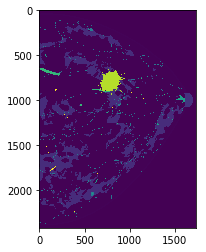

In [3]:
a = np.fromfile('/media/pranjal/cewitdata1/pranjal/CT-RECON-DATA/pcl_22183101_crop.raw', dtype='uint8')
a = np.reshape(a, [1140, 2415, 1740])
#  1740   2415   1140

print(a.shape)

#temp = a[666]
plt.imshow(a[500])

In [4]:
temp1 = np.load('calcification_cluster.npy')
print(temp1.shape)

(750, 350)


In [89]:
a1    = a[500, 1500:1500+temp1.shape[0], 150:150+temp1.shape[1]]
temp1[temp1 != 250] = a1[temp1 != 250]

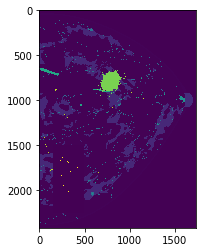

In [6]:
#a[499, 1500:1500+temp1.shape[0], 150:150+temp1.shape[1]] =  temp1
#a[500, 1500:1500+temp1.shape[0], 150:150+temp1.shape[1]] =  temp1
#a[501, 1500:1500+temp1.shape[0], 150:150+temp1.shape[1]] =  temp1

plt.imshow(a[501])

In [7]:
a.tofile('/media/pranjal/cewitdata1/pranjal/CT-RECON-DATA/pcl_22183101_crop_calci.raw')

In [641]:
e = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3000x1200x58.4_4_0.0005_-0.5_1_anistropic_three_1.raw', dtype='float32')
e = np.reshape(e, [58, 1200, 3000])

temp               = e[27]#, 900:1150, 950:1350]
temp[temp < 0.03] = 0
temp[temp > 0.03] = 1
#plt.imshow(temp, cmap='gray')

non_zero_index = np.nonzero(temp)

print(non_zero_index[0].shape, non_zero_index[1].shape)
print(a.shape, b.shape, e.shape)

(858161,) (858161,)
(58, 1200, 3000) (58, 1200, 3000) (58, 1200, 3000)


(858161,) (858161,)
85821 85821 858161
(85821, 1, 5, 5, 5) (85821, 1)


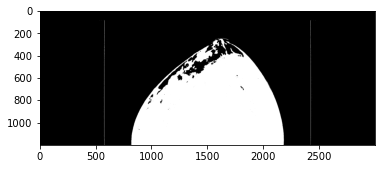

In [3]:
# [STAR] For creating the dataset to train the potential function

e = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3000x1200x58.4_4_0.0005_-0.5_1_anistropic_three_1.raw', dtype='float32')
e = np.reshape(e, [58, 1200, 3000])

a = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3200x1280x58.0_0_0.0005_0_1_anistropic_normal8_1.raw', dtype='float32')
#a = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3000x1200x58.0_1_0.0005_0.5_1_anistropic_normalmlp1_1.raw', dtype='float32')
#a = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3000x1200x58.0_0_0.0005_0.5_1_anistropic_normalmlp1_1.raw', dtype='float32')
a = np.reshape(a, [58, 1280, 3200])

#b = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3000x1200x58.0_1_0.0005_0_1_anistropic_normal_1.raw', dtype='float32')
#b = np.reshape(b, [58, 1200, 3000])

#c = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3000x1200x58.0_1_0.0005_0_1_anistropic_three_1.raw', dtype='float32')
#c = np.reshape(c, [58, 1200, 3000])

d = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3200x1280x58.0_0_0.0005_-0.1_1_anistropic_three8_1.raw', dtype='float32')
d = np.reshape(d, [58, 1280, 3200])

#temp1 = a[:, 900:1150, 950:1350]
#D2    = d[:, 900:1150, 950:1350]

Y_array = d
X_array = a


# For getting the locations of the training data points

temp               = e[27]#, 900:1150, 950:1350]
temp[temp < 0.03] = 0
temp[temp > 0.03] = 1

#temp[temp < 0.045] = 0
plt.imshow(temp, cmap='gray')

non_zero_index = np.nonzero(temp)

print(non_zero_index[0].shape, non_zero_index[1].shape)
#print(a.shape, b.shape, e.shape)


# Generate the samples for the Regression Model

X      = []
Y      = []
voxels = 5


for i in range(non_zero_index[0].shape[0]):
    if np.random.rand() > 0.1:
        continue
    
    ind_z = random.randint(15, 45)
    ind_y = non_zero_index[0][i]
    ind_x = non_zero_index[1][i]
    
    tx = X_array[ind_z-2:ind_z+3, non_zero_index[0][i]-2:non_zero_index[0][i]+3, non_zero_index[1][i]-2:non_zero_index[1][i]+3]
    #ty = Y_array[ind_z-2:ind_z+3, non_zero_index[0][i]-2:non_zero_index[0][i]+3, non_zero_index[1][i]-2:non_zero_index[1][i]+3]
    ty = Y_array[ind_z,           non_zero_index[0][i], non_zero_index[1][i]]
    
    if len(tx.flatten()) ==  voxels*voxels*voxels:
        X.append([tx])# - X_array[ind_z, non_zero_index[0][i], non_zero_index[1][i]])
        Y.append([ty])

print(len(X), len(Y), non_zero_index[0].shape[0])

X =  np.array(X)
#X =  np.reshape(X, [X.shape[0], voxels*voxels*voxels])
Y =  np.array(Y)
#Y =  np.reshape(Y, [Y.shape[0], voxels*voxels*voxels])

print(X.shape, Y.shape)

In [4]:
def weights_init_uniform(m):
    classname = m.__class__.__name__
    print('classname is ', classname)
    
    # for every Linear layer in a model..
    #if classname.find('Linear') != -1:
    # apply a uniform distribution to the weights and a bias=0
    m.weight1.data.uniform_(0.0, 0.03)
    m.bias1.data.data.uniform_(0.0, 0.03)#.fill_(0)
    
    m.weight2.data.uniform_(0.0, 0.03)
    m.bias2.data.data.uniform_(0.0, 0.03)#.fill_(0)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.001)

#weights_init_uniform(model)

In [13]:
# For training the Regression Model using PyTorch

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

device         = torch.device("cuda:0")

model  = RegCNND()
init_weights(model)
model.cuda()


criterion          = nn.L1Loss(reduction='mean')#nn.MSELoss(reduction='mean')#nn.L1Loss(reduce=False, )#.MSELoss()
optimizer_student  = optim.Adam(model.parameters(), lr=0.0001)#, weight_decay=0.01)

def evaluate_result(model, valx, valy):
    model.eval()
    
    val_dice       = []
    batch_size     = 100
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size]#.T
        y = valy[ik*batch_size:(ik+1)*batch_size]

        x = torch.tensor(x, device=device).float()

        output = model.forward(x)
        output = output.data.cpu().numpy()
        
        dt = np.abs(y - output)
        dt = np.mean(dt)
        
        val_dice.append(dt)
    return val_dice

def train_model(model, batch_size, optimizer, criterion, trainx, trainy):
    loss_array = []
    
    model.train()
    
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size]#.T
        y = trainy[i*batch_size:(i+1)*batch_size]#.T
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        
        #print(x.shape, y.shape)
        optimizer.zero_grad()
        output = model.forward(x)
        #print(i, output.shape, y.shape)
        
        loss   = criterion(output , y)
        #print(i, output.shape, loss.shape, y.shape)
        #loss   = torch.mean(loss)
        #print(loss.shape)
        loss.backward()
        
        loss_array.append(loss.item())
        optimizer.step()
    
    loss_array = np.mean(loss_array)
    return loss_array

#X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

prev_min = 1000

for i in range(10000):
    index = np.random.permutation(len(X_train))
    
    X_train = X_train[index]
    y_train = y_train[index]
    
    train_model(model, 64, optimizer_student, criterion, X_train, y_train)
    result = evaluate_result(model, X_test, y_test)
    
    if np.mean(result) < prev_min:
        prev_min = np.mean(result)
        print(i, 'Validation Accuracy ', np.mean(result))
        torch.save(model.state_dict(), 'conv_prior_1-out_8-filter_loss.pt')

0 Validation Accuracy  0.007004612
1 Validation Accuracy  0.0005201878
2 Validation Accuracy  0.00023408422
4 Validation Accuracy  0.00021693288
5 Validation Accuracy  0.000208495
6 Validation Accuracy  0.00020386226
7 Validation Accuracy  0.00019916958
8 Validation Accuracy  0.00019836106
9 Validation Accuracy  0.00018804193
10 Validation Accuracy  0.0001854027
13 Validation Accuracy  0.00017951554
15 Validation Accuracy  0.00017731049
17 Validation Accuracy  0.00017239638
18 Validation Accuracy  0.00017114171
19 Validation Accuracy  0.0001701624
21 Validation Accuracy  0.00016862054
23 Validation Accuracy  0.00016833055
26 Validation Accuracy  0.0001661482
30 Validation Accuracy  0.00016370388
34 Validation Accuracy  0.00016233067
37 Validation Accuracy  0.00016098037
43 Validation Accuracy  0.00015899299
48 Validation Accuracy  0.00015693196
50 Validation Accuracy  0.00015647529
54 Validation Accuracy  0.00015478504
55 Validation Accuracy  0.00015462797
57 Validation Accuracy  0.000

KeyboardInterrupt: 

In [149]:
# 8  Filters: 944 Validation Accuracy  0.00019152784
# 16 Filters: 191 Validation Accuracy  0.00016972028


def predict_result(model, valx, valy):
    model.eval()
    
    val_dice       = []
    batch_size     = 1
    
    result       = []
    ground_truth = []
    inputx       = []
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size]#.T
        y = valy[ik*batch_size:(ik+1)*batch_size]#.T

        x = torch.tensor(x, device=device).float()

        output = model.forward(x)
        output = output.data.cpu().numpy()
        
        inputx.append(x.data.cpu().numpy())
        result.append(output)
        ground_truth.append(y)
    
    return inputx, result, ground_truth

inputx, result, ground_truth = predict_result(model, X_test, y_test)


In [151]:
index = random.randint(0, len(ground_truth)-1)

print(ground_truth[index].flatten()[:10])
print(result[index].flatten()[:10])
print(inputx[index].flatten()[:10])

[0.0274774  0.02770412 0.0278193  0.02821443 0.02832329 0.02766821
 0.02784521 0.02813914 0.02809513 0.02810374]
[0.0276094  0.02784416 0.02812788 0.02816381 0.02794264 0.02756655
 0.02751802 0.02824509 0.02800724 0.02815021]
[0.02745346 0.0275628  0.02774386 0.02795756 0.02773485 0.02730051
 0.02720966 0.02798974 0.02773749 0.02789255]


In [6]:
#torch.save(model.state_dict(), 'conv_prior_1-out_8-filter_0.0001368996_loss.pt')

torch.save(model.state_dict(), 'conv_prior_1-out_32-filter_0.0001262981_loss.pt')


# 195 -> 0.0056678

In [ ]:
# 1500  Validation Accuracy  0.005796282 -> 500       (Per voxel)
# 1500  Validation Accuracy  0.005799574 -> 125       (Per voxel)
# 1500  Validation Accuracy  0.006036232 ->  25       (Per voxel)
# 10000 Validation Accuracy  0.00512195  -> 500       (Per voxel) 
# 23427 Validation Accuracy  0.00366580  -> 125       (Per voxel)
# 1639  Validation Accuracy  0.00320234  -> 125 x 125 (Per voxel)
# 10100 Validation Accuracy  0.00266177  -> 125 x 125 (Per voxel)

# conv_prior_1-out_8-filter_0.0001368996_loss.pt -> 16 filter with padding -> all out
# 1500  Validation Accuracy  0.00013689  -> 125       (All voxels)

# 2501  Validation Accuracy  0.00012629  -> 125


# conv_prior_1-out_16-filter_loss.pt
# 3196 Validation Accuracy  0.00012279117 -> 125

In [ ]:
# For training the Regression Model

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

#X, y = make_regression(n_samples=200, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


#X_train = X_train*100
#X_test  = X_test*100
#y_train = y_train*100
#y_test  = y_test*100

regr   = MLPRegressor(activation='tanh', 
                      random_state=0, 
                      solver='adam',
                      learning_rate_init=0.0001,
                      #learning_rate='adaptive', 
                      #hidden_layer_sizes=(125,25,),
                      hidden_layer_sizes=(125,),
                      #verbose=True,
                      tol=0.00001,
                      alpha=0.0001, max_iter=500).fit(X_train, y_train)

result = regr.predict(X_test)

from sklearn.metrics import r2_score

print('Score is ', r2_score(result, y_test))
#print(result.shape, X_test.shape, y_test.shape)

error = result - y_test
error = np.square(error)
print('Error is ', np.mean(error)*10000)

(64165, 125) (21389, 125) (64165,) (21389,)


In [715]:
print(regr.coefs_[0].shape, regr.coefs_[1].shape, regr.intercepts_[0].shape, regr.intercepts_[1].shape)

np.save('mlp_coefs0_0.npy',      regr.coefs_[0])
np.save('mlp_coefs0_1.npy',      regr.coefs_[1])
np.save('mlp_intercepts0_0.npy', regr.intercepts_[0])
np.save('mlp_intercepts0_1.npy', regr.intercepts_[1])

(125, 25) (25, 1) (25,) (1,)


In [580]:
print(regr.coefs_[0].shape, X_test[0].shape, temp_mat.shape)

(125, 125) (125,) (125, 125)


In [582]:
#temp_mat = regr.coefs_[0]
temp_ans = np.matmul(X_test[0], temp_mat)
print(temp_ans.shape)
print(temp_ans[:5])

(125,)
[ 2.25638378e-02  5.97776647e-05  2.04450502e-03 -1.37875284e-03
  7.12371572e-04]


In [594]:
#temp_mat = regr.coefs_[0]
temp_ans = np.dot(X_test[0], temp_mat)
print(temp_ans.shape)
print(temp_ans[:5])

(125,)
[ 2.25638378e-02  5.97776647e-05  2.04450502e-03 -1.37875284e-03
  7.12371572e-04]


In [589]:
a = np.array([[1, 2]])
b = np.array([[1, 2], [3, 4]])

print(a.shape, b.shape)
c = np.dot(a, b)
print(c.shape)

print(c)

(1, 2) (2, 2)
(1, 2)
[[ 7 10]]


In [593]:
temp_ans = [0]*125

for i in range(125):
    ans  = 0
    for j in range(125):
        ans = ans + X_test[0][j]*temp_mat[j][i]
    temp_ans[i] = ans
print(temp_ans[:5])

[0.02256383776164464, 5.9777664652542646e-05, 0.0020445050174381827, -0.0013787528351919486, 0.0007123715720690025]


In [596]:
#print(intercepts[0].shape)
#print(np.dot(X_test, c[0]).shape)
tp1 = np.dot(X_test, regr.coefs_[0])
tp2 = tp1 + regr.intercepts_[0]
tp3 = np.tanh(tp2)

print(tp3.shape, regr.coefs_[1].shape, regr.intercepts_[1].shape)

tp4 = np.dot(tp3, regr.coefs_[1])
tp4 = tp4 + regr.intercepts_[1]

#print(intercepts[0][:5])
#print(tp1[0][:5])
#print(tp2[0][:5])
print(tp4.shape)
print(tp4[:5])

(1396, 125) (125, 1) (1,)
(1396, 1)
[[0.03706854]
 [0.02758618]
 [0.03662279]
 [0.03742097]
 [0.03690861]]


In [695]:
mlp_coefs_0_orig      = np.load('/home/pranjal/SEMISUNET/mlp_coefs0_0.npy')
mlp_coefs_1_orig      = np.load('/home/pranjal/SEMISUNET/mlp_coefs0_1.npy')
mlp_intercepts_0_orig = np.load('/home/pranjal/SEMISUNET/mlp_intercepts0_0.npy')
mlp_intercepts_1_orig = np.load('/home/pranjal/SEMISUNET/mlp_intercepts0_1.npy')

print(mlp_coefs_0_orig.shape, mlp_coefs_1_orig.shape)
print(mlp_intercepts_0_orig.shape, mlp_intercepts_1_orig.shape)

(125, 25) (25, 1)
(25,) (1,)


In [539]:
# Forward propagate

activation = X_test
for i in range(regr.n_layers_ - 1):
    activation = np.dot(activation, regr.coefs_[i])
    activation += regr.intercepts_[i]
    if i != regr.n_layers_ - 2:
        activation = np.tanh(activation)

print(activation.shape)
#output_activation = ACTIVATIONS[self.out_activation_]
#output_activation(activation)

(1396, 1)


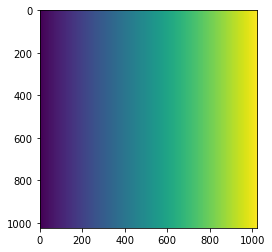

In [3]:
# Understanding Numba Code

import numpy
from numba import cuda

def escape_time(p, maxtime):
    """Perform the Mandelbrot iteration until it's clear that p diverges
    or the maximum number of iterations has been reached.
    """
    z = 0j
    for i in range(maxtime):
        z = z ** 2 + p
        if abs(z) > 2:
            return i
    return maxtime

escape_time_gpu = cuda.jit(device=True)(escape_time)

@cuda.jit
def mandelbrot_gpu(M, real_min, real_max, imag_min, imag_max):
    """Calculate the Mandelbrot set on the GPU.
    
    Parameters
    ----------
    M : numpy.ndarray
        a two-dimensional integer array that will contain the 
        escape times for each point.
    real_min: float
        minimum value on the real axis
    real_max: float
        maximum value on the real axis
    imag_min: float
        minimum value on the imaginary axis
    imag_max: float
        maximum value on the imaginary axis
    """
    ny, nx = M.shape
    i, j = cuda.grid(2)
    
    if i < ny and j < nx:
        dx = (real_max - real_min) / nx
        dy = (imag_max - imag_min) / ny
        p = real_min + dx * i + (imag_min + dy * j) * 1j
        M[i, j] = j#escape_time_gpu(p, 20)
        
        
M = numpy.zeros((1024, 1024), dtype=numpy.int32)
block = (32, 32)
grid = (M.shape[0] // block[0] if M.shape[0] % block[0] == 0 
            else M.shape[0] // block[0] + 1,
        int(M.shape[0] // block[1] if M.shape[1] % block[1] == 0 
            else M.shape[1] // block[1] + 1))


mandelbrot_gpu[grid, block](M, -2.0, 2.0, -1.6, 1.6)

plt.imshow(M, interpolation="nearest")


In [717]:
# Predicted Value from Regression Model is

a = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3200x1280x58.0_0_0.0005_0_1_anistropic_normal8_1.raw', dtype='float32')
a = np.reshape(a, [58, 1280, 3200])

d = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3200x1280x58.0_0_0.0005_-0.1_1_anistropic_three8_1.raw', dtype='float32')
d = np.reshape(d, [58, 1280, 3200])

Y_array = d
X_array = a

ind_z = 43
ind_y = 1000
ind_x = 2200

tx = X_array[ind_z-2:ind_z+3, ind_y-2:ind_y+3, ind_x-2:ind_x+3]
ty = Y_array[ind_z,           ind_y, ind_x]

X_test = np.array([tx.flatten()])
print(X_test.shape)

tp1 = np.dot(X_test, regr.coefs_[0])
tp2 = tp1 + regr.intercepts_[0]
tp3 = np.tanh(tp2)

print(tp3.shape, regr.coefs_[1].shape, regr.intercepts_[1].shape)

tp4 = np.dot(tp3, regr.coefs_[1])
tp4 = tp4 + regr.intercepts_[1]

print('Predicted Value From Model is ', tp4)
print('Ground Truth Value is         ', ty)
print(X_array[ind_z,           ind_y, ind_x])

(1, 125)
(1, 25) (25, 1) (1,)
Predicted Value From Model is  [[0.02117195]]
Ground Truth Value is          0.021088189
0.0209226


In [718]:
e = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3200x1280x58.0_0_0.0005_0_1_anistropic_result8_a_1.raw', dtype='float32')
e = np.reshape(e, [58, 1280, 3200])

In [722]:
print(e[27, 1152, 1315])
print(d[27, 1152, 1315])
print(d[27, 1152, 1315] - e[27, 1152, 1315])

0.039948188
0.04013158
0.00018339232


In [2]:
import numba
from numba import njit, prange
from numba import cuda

In [10]:
# Define the dimensions of the volume
IMGSIZx = 3200
IMGSIZy = 1280
IMGSIZz = 58

# Cuda Kernel to calculate mean of neighboring voxels for each voxel
@cuda.jit(debug=True)
def calculate_mean(outbuf, inbuf):
    # Calculate the index of the voxel being considered
    
    ind_x, ind_y, ind_z = cuda.grid(3)
    #ind_x = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    #ind_y = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    #ind_z = cuda.blockIdx.z * cuda.blockDim.z + cuda.threadIdx.z
    
    if ind_x < 0 or  ind_y < 0 or  ind_z < 0:
        return
    
    if ind_x > IMGSIZx-1 or ind_y > IMGSIZy-1 or ind_z > IMGSIZz-1:
        return
    
    sum1    = 0.0
    counter = 0
    for ind_nr_z in range(ind_z-2, ind_z+3):
        for ind_nr_y in range(ind_y-2, ind_y+3):
            for ind_nr_x in range(ind_x-2, ind_x+3):
                if ind_nr_x<0 or ind_nr_y<0 or ind_nr_z<0:
                    continue
                
                if ind_nr_x>(IMGSIZx-1) or ind_nr_y>(IMGSIZy-1) or ind_nr_z>(IMGSIZz-1):
                    continue
                
                sum1    = sum1 + inbuf[ind_nr_z, ind_nr_y, ind_nr_x]
                counter = counter+1
    
    outbuf[ind_z, ind_y, ind_x] = sum1/counter
    return


# Create random input matrix for which to calculate voxel wise mean
inbuf = np.random.rand(58, 1280, 3200)
# Create output matrix to store the output 
outbuf  = np.zeros((58, 1280, 3200), np.float32)



# Code to Launch the Cuda kernel in Numba
# 8*400 = 3200 = IMGSIZx
# 8*160 = 1280 = IMGSIZy
# 2*29  = 58   = IMGSIZz
THREADS_PER_BLOCK = (8, 8, 2)
BLOCKS_PER_GRID   = (400, 160, 29)
calculate_mean[BLOCKS_PER_GRID, THREADS_PER_BLOCK](outbuf, inbuf)
cuda.synchronize()



# Checking result for a random voxel (c_z, c_y, c_x)
c_x = random.randint(0, IMGSIZx)
c_y = random.randint(0, IMGSIZy)
c_z = random.randint(0, IMGSIZz)
result_manual = np.mean(inbuf[c_z-2:c_z+3,c_y-2:c_y+3,c_x-2:c_x+3])
result_cuda   = outbuf[c_z, c_y, c_x]
print(result_manual, result_cuda)

0.5002435831882374 0.5002436


In [5]:
# Checking result for a random voxel (c_z, c_y, c_x)
c_x = random.randint(0, IMGSIZx)
c_y = random.randint(0, IMGSIZy)
c_z = random.randint(0, IMGSIZz)
result_manual = np.mean(inbuf[c_z-2:c_z+3,c_y-2:c_y+3,c_x-2:c_x+3])
result_cuda   = outbuf[c_z, c_y, c_x]
print(result_manual, result_cuda)

0.4530233603179261 0.45302337


In [6]:
print(c_x, c_y, c_z)

84 542 22


In [7]:
result_manual = np.mean(inbuf[c_z-2:c_z+3,c_y-2:c_y+3,c_x-2:c_x+3].flatten())

In [8]:
print(result_manual)

0.4530233603179261
